## We describe a technique to extract interesting topics from reviews and assign sentiment labels to these topics.

Our aim is to automatically mine these types of topics
from the raw review text and to automatically assign sentiment
labels to the relevant topics and review elements. We
describe and evaluate how such features can be used to predict
review quality (helpfulness). Further we show how this
can be used as the basis of a review recommendation system
to automatically recommend high quality reviews even in the
absence of any explicit helpfulness feedback.

#### Sentiment analysis refers to the use of natural language processing, text analysis and statistical learning to identify and extract subjective information in source materials.

In simple terms, sentiment analysis aims to determine the attitude of a speaker or a writer with respect to some topic or the overall contextual polarity of a document. In our case we will use it to determine if a text has a positive, negative, or neutral mood or animosity.

So in the sentiment analysis process there are a couple of stages more or less differentiated. The first is about processing natural language, and the second about training a model. The first stage is in charge of processing text in a way that, when we are ready to train our model, we already know what variables the model needs to consider as inputs. The model itself is in charge of learning how to determine the sentiment of a piece of text based on these variables. 

In [1]:
# Import the pandas package, then use the "read_csv" function to read
# the labeled training data
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
warnings.filterwarnings('ignore') 
train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\HostelWorld\train_review_data.csv")

##### Exploring the columns with Permutation and Random Sampling
To select a random subset without replacement, one way is to slice off the k elements of an array returned by permutation, where k is the desired subet size.

In [2]:
sampler = np.random.permutation(5)

In [3]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.take.html
train.take(sampler)

,customer_id,review_id,review_score,review_text,HostelNumber,review_date,review_language
0,309693,6085536,86,the space in the rooms is not enough specially...,4815.0,2014-01-10 15:34:36,English
1,309693,6244624,97,the wi fi doesn t work properly,34160.0,2014-04-21 20:32:25,English
2,309693,6244607,94,beddings and pillows need to be replaced for n...,65881.0,2014-04-21 20:18:44,English
3,459093,6895146,91,i had a few problems with the free unlimited w...,36020.0,2015-01-09 07:26:36,English
4,459093,5238648,89,this is a very pleasant hostel the staff were ...,12168.0,2013-01-18 03:52:21,English


In [6]:
randomSample = train.take(np.random.permutation(len(train))[:3])
randomSample

,customer_id,review_id,review_score,review_text,HostelNumber,review_date,review_language
573626,573130619,5763640,83,muy buena atencia n ubicacia n excelente pero ...,282.0,2013-08-17 12:17:06,Spanish
487465,551371182,4516036,100,encantados con este hostel de lo mejor que hem...,20779.0,2012-04-05 18:29:32,Spanish
284012,478787780,5159561,89,excelente hotel perto da estaa a o excelente c...,47841.0,2012-12-07 09:22:25,Brazilian Portuguese


##### Let us take a small sample of 100 rows of the dataset 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html

In [7]:
df = train.sample(n=100)

###### Select only review_language english

In [15]:
df = df.loc[df['review_language'] == ('English')]
df = df.set_index('customer_id')

In [16]:
print ("\n\n---------------------")
print ("SAMPLE SET INFORMATION")
print ("---------------------")
print ("Shape of df:", df.shape, "\n")
print ("Column Headers:", list(df.columns.values), "\n")
print (df.dtypes)



---------------------
SAMPLE SET INFORMATION
---------------------
Shape of df: (85, 6) 

Column Headers: ['review_id', 'review_score', 'review_text', 'HostelNumber', 'review_date', 'review_language'] 

review_id            int64
review_score         int64
review_text         object
HostelNumber       float64
review_date         object
review_language     object
dtype: object


##### There are no missing values in the sample

###### Let us just focus on review_text. I want to do some sentiment analysis

Manually label with 1 (positive sentiment) or 0 (negative sentiment) and create a column called sentiment.

http://stackoverflow.com/questions/18942506/add-new-column-in-pandas-dataframe-python

In [67]:
df['Sentiment'] = 0

In [68]:
df.to_csv("sub.csv",index=False)

##### Amended the file manually. 80 was the cut-off point. less than 80 negative reviews and more it was positive.

In [69]:
#Import the amended file
df_1 = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\HostelWorld\sample_data_amended.csv")

##### Show the the values of review_score across the levels of Sentiment

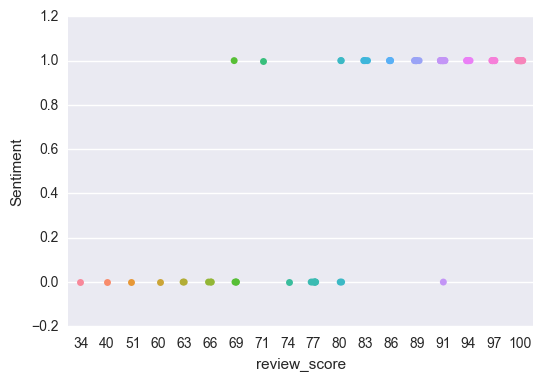

In [71]:
sns.stripplot(x="review_score", y="Sentiment", data=df_1, jitter=True);

### For a small dataset, most of the people's reviews are consistent with the score they give.

#### More exploration of text

Let's calculate the average number of words per sentence. We could do the following using a list comprehension with the number of words per sentence.

In [72]:
np.mean([len(s.split(" ")) for s in df_1.review_text])

45.364705882352943

##### People have a lot to say in thier reviews

##### Preparing a corpus

In linguistics, a corpus or text corpus is a large and structured set of texts (nowadays usually electronically stored and processed). They are used to do statistical analysis and hypothesis testing, checking occurrences or validating linguistic rules within a specific language territory. In our particular case, we are talking about the collection of text fragments that we want to classify in either positive or negative sentiment.

We will also extract important words and establish them as input variables for our classifier.

http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html

The class sklearn.feature_extraction.text.CountVectorizer in the wonderful scikit learn Python library converts a collection of text documents to a matrix of token counts. This is just what we need to implement later on our bag-of-words linear classifier.

First we need to init the vectoriser. We need to remove punctuations, lowercase, remove stop words, and stem words. All these steps can be directly performed by CountVectorizer if we pass the right parameter values. We can do this as follows. Notice that for the stemming step, we need to provide a stemmer ourselves. We will use a basic implementation of a Porter Stemmer, a stemmer widely used named after its creator.

In [73]:
import re, nltk
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer

#######
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems
######## 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    max_features = 120
)

We pas a few parameters to the vectoriser including our tokenizer that removes non-letters and performs the stemming, together with lowercasing and removing english stop-words. Although we can also pass a sparsity coefficient to this class, we hace decided to directly specify how many terms to we want in our final vectors (i.e. 120).

The method fit_transform does two functions: First, it fits the model and learns the vocabulary; second, it transforms our corpus data into feature vectors. The input to fit_transform should be a list of strings, so we concatenate train and test data as follows.

In [74]:
corpus_data_features = vectorizer.fit_transform(
    df_1.review_text.tolist())

##### Numpy arrays are easy to work with, so convert the result to an array.

In [75]:
corpus_data_features_nd = corpus_data_features.toarray()
corpus_data_features_nd.shape

(85, 120)

##### Let take a look at the words in the vocabulary.

In [76]:
vocab = vectorizer.get_feature_names()
print (vocab)

['alway', 'area', 'arriv', 'atmospher', 'awesom', 'bathroom', 'beach', 'beauti', 'bed', 'best', 'better', 'big', 'bit', 'block', 'book', 'breakfast', 'center', 'cheap', 'citi', 'clean', 'close', 'cold', 'comfort', 'common', 'cool', 'crawl', 'd', 'day', 'definit', 'don', 'door', 'easi', 'everyon', 'everyth', 'everywher', 'excel', 'expect', 'experi', 'facil', 'famili', 'fantast', 'free', 'friend', 'friendli', 'girl', 'good', 'got', 'great', 'ha', 'hang', 'help', 'hi', 'hostel', 'hotel', 'huge', 'includ', 'just', 'kitchen', 'light', 'like', 'littl', 'live', 'locat', 'lot', 'love', 'main', 'make', 'meet', 'minut', 'money', 'near', 'new', 'nice', 'night', 'onc', 'onli', 'outdoor', 'outsid', 'overal', 'owner', 'parti', 'pay', 'peopl', 'perfect', 'place', 'pretti', 'price', 'quiet', 'realli', 'recommend', 'relax', 'road', 'room', 's', 'secur', 'shower', 'sleep', 'small', 'somewher', 'space', 'staff', 'station', 'stay', 'super', 'sure', 't', 'thank', 'thi', 'thing', 'time', 'travel', 'use', 'v

###### We can also print the counts of each word in the vocabulary as follows.

In [77]:
# Sum up the counts of each vocabulary word
dist = np.sum(corpus_data_features_nd, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the data set
for tag, count in zip(vocab, dist):
    print (count, tag)

4 alway
18 area
6 arriv
6 atmospher
4 awesom
8 bathroom
4 beach
5 beauti
11 bed
5 best
4 better
4 big
12 bit
4 block
5 book
14 breakfast
4 center
5 cheap
6 citi
25 clean
6 close
6 cold
4 comfort
9 common
7 cool
4 crawl
3 d
7 day
3 definit
4 don
5 door
6 easi
5 everyon
6 everyth
3 everywher
4 excel
4 expect
5 experi
5 facil
6 famili
3 fantast
5 free
4 friend
23 friendli
3 girl
39 good
4 got
38 great
6 ha
5 hang
21 help
5 hi
60 hostel
4 hotel
4 huge
4 includ
8 just
6 kitchen
4 light
10 like
6 littl
4 live
26 locat
10 lot
13 love
7 main
6 make
5 meet
6 minut
4 money
5 near
7 new
36 nice
13 night
3 onc
13 onli
3 outdoor
3 outsid
6 overal
4 owner
3 parti
3 pay
10 peopl
6 perfect
23 place
8 pretti
8 price
5 quiet
19 realli
10 recommend
5 relax
4 road
42 room
22 s
4 secur
8 shower
5 sleep
5 small
4 somewher
4 space
44 staff
4 station
40 stay
6 super
4 sure
14 t
4 thank
27 thi
5 thing
15 time
10 travel
4 use
4 ve
49 veri
69 wa
17 walk
4 want
6 way
5 wifi
8 work


#### Clean, Friendliness, stay, hostel, place, great location, good area seems to be some the most important words people use to descibe.

#### Surprisingly, cheap and price is not talked much about considering we are reviewing a hostel.

It is
possible to classify a review based on the
average semantic orientation of phrases in
the review that contain adjectives and adverbs. We expect that there will be value
in combining semantic orientation with more traditional text
classification methods for review
classification